# MVP: Drug-Disease Adverse Outcome Prediction

**Scope**: 1-2 disease areas, 10-20 drugs with known adverse outcomes, binary outcome prediction

**Approach**:
- **GDi**: Disease → Associated Genes (PrimeKG) → Pathways (PrimeKG)
- **GDr**: Drugs → Target Genes (PrimeKG) → Pathways (PrimeKG)
- **Features**: Shared genes, shared pathways, pathway overlap, graph distance
- **Baseline**: Simple PrimeKG embeddings
- **Models**: Logistic Regression & Random Forest (no GNNs yet)

**Reference**: See `explore_primekg.ipynb` for PrimeKG dataset details


## 1. Setup & Dependencies


In [1]:
# Install dependencies
%pip install pandas numpy networkx scikit-learn matplotlib seaborn tqdm requests node2vec -q


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Dependencies loaded successfully!")


Dependencies loaded successfully!


## 2. Download PrimeKG

PrimeKG is available from Harvard Dataverse. Reference: `explore_primekg.ipynb` for details.


In [3]:
import os
import requests

# PrimeKG download URL from Harvard Dataverse
PRIMEKG_URL = "https://dataverse.harvard.edu/api/access/datafile/6180620"
DATA_PATH = "data/kg.csv"  # Use full PrimeKG dataset (8.1M edges)

def download_primekg(url, filepath, chunk_size=8192):
    """Download PrimeKG dataset with progress bar."""
    if os.path.exists(filepath):
        print(f"Dataset already exists at {filepath}")
        return
    
    print(f"Downloading PrimeKG from {url}...")
    print("Note: This is ~1GB and may take several minutes.")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    with open(filepath, 'wb') as f:
        with tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading") as pbar:
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))
    
    print(f"Download complete! Saved to {filepath}")

# Download the dataset
download_primekg(PRIMEKG_URL, DATA_PATH)

Dataset already exists at data/kg.csv


## 3. Load PrimeKG Data


In [4]:
# Load the dataset
print("Loading PrimeKG dataset...")
df = pd.read_csv(DATA_PATH, low_memory=False)
print(f"Dataset loaded: {df.shape[0]:,} edges, {df.shape[1]} columns")
print(f"Columns: {list(df.columns)}")
df.head()


Loading PrimeKG dataset...


Dataset loaded: 8,100,498 edges, 12 columns
Columns: ['relation', 'display_relation', 'x_index', 'x_id', 'x_type', 'x_name', 'x_source', 'y_index', 'y_id', 'y_type', 'y_name', 'y_source']


,relation,display_relation,x_index,x_id,x_type,x_name,x_source,y_index,y_id,y_type,y_name,y_source
0,protein_protein,ppi,0,9796,gene/protein,PHYHIP,NCBI,8889,56992,gene/protein,KIF15,NCBI
1,protein_protein,ppi,1,7918,gene/protein,GPANK1,NCBI,2798,9240,gene/protein,PNMA1,NCBI
2,protein_protein,ppi,2,8233,gene/protein,ZRSR2,NCBI,5646,23548,gene/protein,TTC33,NCBI
3,protein_protein,ppi,3,4899,gene/protein,NRF1,NCBI,11592,11253,gene/protein,MAN1B1,NCBI
4,protein_protein,ppi,4,5297,gene/protein,PI4KA,NCBI,2122,8601,gene/protein,RGS20,NCBI


## 4. Select Disease Areas & Drugs with Adverse Outcomes

We'll focus on diseases with contraindications (known adverse drug outcomes).


In [5]:
# Extract drug-disease relationships
drug_disease_mask = (
    ((df['x_type'] == 'drug') & (df['y_type'] == 'disease')) |
    ((df['x_type'] == 'disease') & (df['y_type'] == 'drug'))
)
drug_disease_df = df[drug_disease_mask].copy()

# Normalize direction: always drug -> disease
def normalize_drug_disease(row):
    if row['x_type'] == 'drug':
        return pd.Series({
            'drug_id': row['x_id'],
            'drug_name': row['x_name'],
            'disease_id': row['y_id'],
            'disease_name': row['y_name'],
            'relation': row['relation']
        })
    else:
        return pd.Series({
            'drug_id': row['y_id'],
            'drug_name': row['y_name'],
            'disease_id': row['x_id'],
            'disease_name': row['x_name'],
            'relation': row['relation']
        })

drug_disease_normalized = drug_disease_df.apply(normalize_drug_disease, axis=1)

print(f"Total drug-disease edges: {len(drug_disease_normalized):,}")
print(f"\nRelationship types:")
print(drug_disease_normalized['relation'].value_counts())


Total drug-disease edges: 85,262

Relationship types:
relation
contraindication    61350
indication          18776
off-label use        5136
Name: count, dtype: int64


In [6]:
# MAXIMUM DATASET: Use ALL available diseases and drugs
# Goal: ~15,000+ examples for statistically powerful evaluation

contraindications = drug_disease_normalized[drug_disease_normalized['relation'] == 'contraindication']
indications = drug_disease_normalized[drug_disease_normalized['relation'] == 'indication']

# Find diseases with BOTH contraindications AND indications
diseases_with_contra = set(contraindications['disease_id'])
diseases_with_indica = set(indications['disease_id'])
diseases_with_both = diseases_with_contra & diseases_with_indica

print(f"Diseases with contraindications: {len(diseases_with_contra)}")
print(f"Diseases with indications: {len(diseases_with_indica)}")
print(f"Diseases with BOTH: {len(diseases_with_both)}")

# Get counts for diseases that have both relation types
disease_contra_counts = contraindications[contraindications['disease_id'].isin(diseases_with_both)].groupby(['disease_id', 'disease_name']).size().reset_index(name='contra_count')
disease_indica_counts = indications[indications['disease_id'].isin(diseases_with_both)].groupby(['disease_id', 'disease_name']).size().reset_index(name='indica_count')

# Merge and compute balance ratio
disease_counts = disease_contra_counts.merge(disease_indica_counts[['disease_id', 'indica_count']], on='disease_id')
disease_counts['total'] = disease_counts['contra_count'] + disease_counts['indica_count']
disease_counts['balance_ratio'] = disease_counts[['contra_count', 'indica_count']].min(axis=1) / disease_counts[['contra_count', 'indica_count']].max(axis=1)

# Sort by total edges but filter for reasonable balance (at least 20% minority class)
disease_counts_balanced = disease_counts[disease_counts['balance_ratio'] >= 0.2]
disease_counts_balanced = disease_counts_balanced.sort_values('total', ascending=False)

print(f"\nDiseases with good balance (>=20% minority): {len(disease_counts_balanced)}")
print("\nTop 15 balanced diseases:")
print(disease_counts_balanced.head(15)[['disease_name', 'contra_count', 'indica_count', 'total', 'balance_ratio']].to_string(index=False))

# SELECT ALL 328 DISEASES WITH GOOD BALANCE (MAXIMUM EXPANSION)
N_DISEASES = 328  # Use ALL diseases with good balance
selected_diseases = disease_counts_balanced.head(N_DISEASES)
selected_disease_ids = selected_diseases['disease_id'].tolist()
selected_disease_names = selected_diseases['disease_name'].tolist()

print(f"\n{'='*60}")
print(f"SELECTED {len(selected_disease_ids)} DISEASE AREAS (MAXIMUM)")
print(f"{'='*60}")
print(f"Top 10 diseases by total relationships:")
for i, (did, dname) in enumerate(zip(selected_disease_ids[:10], selected_disease_names[:10])):
    row = disease_counts[disease_counts['disease_id'] == did].iloc[0]
    print(f"  {i+1}. {dname}: {int(row['contra_count'])} contras, {int(row['indica_count'])} indics")
print(f"  ... and {len(selected_disease_ids) - 10} more diseases")

# Get ALL drugs that have relationships with selected diseases
selected_contra = contraindications[contraindications['disease_id'].isin(selected_disease_ids)]
selected_indica = indications[indications['disease_id'].isin(selected_disease_ids)]

all_drugs_contra = set(selected_contra['drug_id'])
all_drugs_indica = set(selected_indica['drug_id'])
all_drugs = all_drugs_contra | all_drugs_indica

print(f"\nDrugs with contraindications for selected diseases: {len(all_drugs_contra)}")
print(f"Drugs with indications for selected diseases: {len(all_drugs_indica)}")
print(f"Total unique drugs: {len(all_drugs)}")

# Get drug counts
drug_contra_counts = selected_contra.groupby(['drug_id', 'drug_name']).size().reset_index(name='contra_count')
drug_indica_counts = selected_indica.groupby(['drug_id', 'drug_name']).size().reset_index(name='indica_count')

drug_counts = drug_contra_counts.merge(drug_indica_counts[['drug_id', 'indica_count']], on='drug_id', how='outer').fillna(0)
drug_counts['total'] = drug_counts['contra_count'] + drug_counts['indica_count']
drug_counts = drug_counts.sort_values('total', ascending=False)

# SELECT TOP 1000 DRUGS (MAXIMUM EXPANSION - will use all available)
N_DRUGS = 1000
selected_drugs = drug_counts.head(N_DRUGS)
selected_drug_ids = selected_drugs['drug_id'].tolist()
selected_drug_names = selected_drugs['drug_name'].tolist()

print(f"\n{'='*60}")
print(f"SELECTED {len(selected_drug_ids)} DRUGS (MAXIMUM)")
print(f"{'='*60}")
print(f"Top 10 drugs by total relationships:")
for i, (did, dname) in enumerate(zip(selected_drug_ids[:10], selected_drug_names[:10])):
    row = drug_counts[drug_counts['drug_id'] == did].iloc[0]
    print(f"  {i+1}. {dname}: {int(row['contra_count'])} contras, {int(row['indica_count'])} indics")
print(f"  ... and {len(selected_drug_ids) - 10} more drugs")

# Preview expected dataset size
expected_positive = len(selected_contra[
    (selected_contra['disease_id'].isin(selected_disease_ids)) &
    (selected_contra['drug_id'].isin(selected_drug_ids))
])
expected_negative = len(selected_indica[
    (selected_indica['disease_id'].isin(selected_disease_ids)) &
    (selected_indica['drug_id'].isin(selected_drug_ids))
])

print(f"\n{'='*60}")
print(f"EXPECTED DATASET SIZE (MAXIMUM EXPANSION):")
print(f"{'='*60}")
print(f"  Positive (contraindications): ~{expected_positive}")
print(f"  Negative (indications): ~{expected_negative}")
print(f"  Total: ~{expected_positive + expected_negative}")
print(f"  Class balance: {min(expected_positive, expected_negative) / max(expected_positive, expected_negative):.1%}")

Diseases with contraindications: 1195
Diseases with indications: 1363
Diseases with BOTH: 621

Diseases with good balance (>=20% minority): 328

Top 15 balanced diseases:
                   disease_name  contra_count  indica_count  total  balance_ratio
                   hypertension           616           206    822       0.334416
          hypertensive disorder           614           206    820       0.335505
               anxiety disorder           360           112    472       0.311111
           peptic ulcer disease           286            72    358       0.251748
                         asthma           256            80    336       0.312500
               intrinsic asthma           158            84    242       0.531646
                allergic asthma           158            84    242       0.531646
       congestive heart failure           188            48    236       0.255319
                           gout           180            42    222       0.233333
         

## 5. Build GDi and GDr Mappings

**GDi**: Disease → Genes → Pathways  
**GDr**: Drug → Target Genes → Pathways


In [7]:
# Build GDi: Disease → Genes → Pathways
print("Building GDi: Disease → Genes → Pathways")
print("=" * 60)

# Step 1: Disease → Genes (disease_protein relation)
disease_gene_edges = df[
    ((df['x_type'] == 'disease') & (df['y_type'] == 'gene/protein') & (df['relation'] == 'disease_protein')) |
    ((df['x_type'] == 'gene/protein') & (df['y_type'] == 'disease') & (df['relation'] == 'disease_protein'))
].copy()

# Normalize to disease -> gene
def normalize_disease_gene(row):
    if row['x_type'] == 'disease':
        return pd.Series({
            'disease_id': row['x_id'],
            'disease_name': row['x_name'],
            'gene_id': row['y_id'],
            'gene_name': row['y_name']
        })
    else:
        return pd.Series({
            'disease_id': row['y_id'],
            'disease_name': row['y_name'],
            'gene_id': row['x_id'],
            'gene_name': row['x_name']
        })

disease_gene_df = disease_gene_edges.apply(normalize_disease_gene, axis=1)

# Step 2: Genes → Pathways (pathway_protein relation)
gene_pathway_edges = df[
    ((df['x_type'] == 'gene/protein') & (df['y_type'] == 'pathway') & (df['relation'] == 'pathway_protein')) |
    ((df['x_type'] == 'pathway') & (df['y_type'] == 'gene/protein') & (df['relation'] == 'pathway_protein'))
].copy()

def normalize_gene_pathway(row):
    if row['x_type'] == 'gene/protein':
        return pd.Series({
            'gene_id': row['x_id'],
            'gene_name': row['x_name'],
            'pathway_id': row['y_id'],
            'pathway_name': row['y_name']
        })
    else:
        return pd.Series({
            'gene_id': row['y_id'],
            'gene_name': row['y_name'],
            'pathway_id': row['x_id'],
            'pathway_name': row['x_name']
        })

gene_pathway_df = gene_pathway_edges.apply(normalize_gene_pathway, axis=1)

# Build GDi mapping: disease_id -> {gene_ids} -> {pathway_ids}
gdi_disease_genes = defaultdict(set)
gdi_gene_pathways = defaultdict(set)
gdi_disease_pathways = defaultdict(set)

# Disease -> Genes
for _, row in disease_gene_df.iterrows():
    gdi_disease_genes[row['disease_id']].add(row['gene_id'])

# Gene -> Pathways
for _, row in gene_pathway_df.iterrows():
    gdi_gene_pathways[row['gene_id']].add(row['pathway_id'])

# Disease -> Pathways (via genes)
for disease_id, gene_ids in gdi_disease_genes.items():
    for gene_id in gene_ids:
        if gene_id in gdi_gene_pathways:
            gdi_disease_pathways[disease_id].update(gdi_gene_pathways[gene_id])

print(f"Diseases with gene associations: {len(gdi_disease_genes)}")
print(f"Genes with pathway associations: {len(gdi_gene_pathways)}")
print(f"Diseases with pathway associations: {len(gdi_disease_pathways)}")

# Check selected diseases
for disease_id in selected_disease_ids:
    n_genes = len(gdi_disease_genes.get(disease_id, set()))
    n_pathways = len(gdi_disease_pathways.get(disease_id, set()))
    disease_name = selected_diseases[selected_diseases['disease_id'] == disease_id]['disease_name'].values[0]
    print(f"\n{disease_name}:")
    print(f"  Genes: {n_genes}, Pathways: {n_pathways}")


Building GDi: Disease → Genes → Pathways


Diseases with gene associations: 5593
Genes with pathway associations: 10849
Diseases with pathway associations: 5123

hypertension:
  Genes: 16, Pathways: 74

hypertensive disorder:
  Genes: 12, Pathways: 59

anxiety disorder:
  Genes: 481, Pathways: 897

peptic ulcer disease:
  Genes: 3, Pathways: 10

asthma:
  Genes: 87, Pathways: 290

intrinsic asthma:
  Genes: 80, Pathways: 266

allergic asthma:
  Genes: 80, Pathways: 266

congestive heart failure:
  Genes: 110, Pathways: 387

gout:
  Genes: 10, Pathways: 47

monogenic obesity:
  Genes: 205, Pathways: 471

ocular hypertension:
  Genes: 3, Pathways: 19

obesity disorder:
  Genes: 205, Pathways: 471

peptic esophagitis:
  Genes: 7, Pathways: 24

gastroesophageal reflux disease:
  Genes: 7, Pathways: 24

esophagitis (disease):
  Genes: 7, Pathways: 24

constipation disorder:
  Genes: 7, Pathways: 27

osteoporosis:
  Genes: 66, Pathways: 298

postmenopausal osteoporosis:
  Genes: 66, Pathways: 298

hemophilia:
  Genes: 2, Pathways: 22

In [8]:
# Build GDr: Drug → Target Genes → Pathways
print("Building GDr: Drug → Target Genes → Pathways")
print("=" * 60)

# Step 1: Drug → Target Genes (drug_protein relation)
drug_gene_edges = df[
    ((df['x_type'] == 'drug') & (df['y_type'] == 'gene/protein') & (df['relation'] == 'drug_protein')) |
    ((df['x_type'] == 'gene/protein') & (df['y_type'] == 'drug') & (df['relation'] == 'drug_protein'))
].copy()

def normalize_drug_gene(row):
    if row['x_type'] == 'drug':
        return pd.Series({
            'drug_id': row['x_id'],
            'drug_name': row['x_name'],
            'gene_id': row['y_id'],
            'gene_name': row['y_name']
        })
    else:
        return pd.Series({
            'drug_id': row['y_id'],
            'drug_name': row['y_name'],
            'gene_id': row['x_id'],
            'gene_name': row['x_name']
        })

drug_gene_df = drug_gene_edges.apply(normalize_drug_gene, axis=1)

# Build GDr mapping: drug_id -> {gene_ids} -> {pathway_ids}
gdr_drug_genes = defaultdict(set)
gdr_drug_pathways = defaultdict(set)

# Drug -> Genes
for _, row in drug_gene_df.iterrows():
    gdr_drug_genes[row['drug_id']].add(row['gene_id'])

# Drug -> Pathways (via genes, reuse gene_pathway mapping)
for drug_id, gene_ids in gdr_drug_genes.items():
    for gene_id in gene_ids:
        if gene_id in gdi_gene_pathways:
            gdr_drug_pathways[drug_id].update(gdi_gene_pathways[gene_id])

print(f"Drugs with gene targets: {len(gdr_drug_genes)}")
print(f"Drugs with pathway associations: {len(gdr_drug_pathways)}")

# Check selected drugs
for drug_id in selected_drug_ids[:5]:
    n_genes = len(gdr_drug_genes.get(drug_id, set()))
    n_pathways = len(gdr_drug_pathways.get(drug_id, set()))
    drug_name = selected_drugs[selected_drugs['drug_id'] == drug_id]['drug_name'].values[0]
    print(f"\n{drug_name}:")
    print(f"  Target Genes: {n_genes}, Pathways: {n_pathways}")


Building GDr: Drug → Target Genes → Pathways


Drugs with gene targets: 6282
Drugs with pathway associations: 6131

Cortisone acetate:
  Target Genes: 3, Pathways: 11

Prednisolone:
  Target Genes: 6, Pathways: 24

Hydrocortisone:
  Target Genes: 22, Pathways: 35

Triamcinolone:
  Target Genes: 8, Pathways: 34

Dexamethasone:
  Target Genes: 27, Pathways: 51


## 6. Build NetworkX Graph for Distance Features


In [9]:
# Build a simplified NetworkX graph for computing distances
# We'll include: drugs, diseases, genes, pathways
print("Building NetworkX graph for distance computation...")

G = nx.Graph()

# Add nodes with types
node_info = {}

# Add disease nodes
for disease_id in selected_disease_ids:
    G.add_node(disease_id, node_type='disease')
    disease_name = selected_diseases[selected_diseases['disease_id'] == disease_id]['disease_name'].values[0]
    node_info[disease_id] = {'name': disease_name, 'type': 'disease'}

# Add drug nodes
for drug_id in selected_drug_ids:
    G.add_node(drug_id, node_type='drug')
    drug_name = selected_drugs[selected_drugs['drug_id'] == drug_id]['drug_name'].values[0]
    node_info[drug_id] = {'name': drug_name, 'type': 'drug'}

# Add gene nodes and edges
all_genes = set()
for disease_id in selected_disease_ids:
    all_genes.update(gdi_disease_genes.get(disease_id, set()))
for drug_id in selected_drug_ids:
    all_genes.update(gdr_drug_genes.get(drug_id, set()))

for gene_id in all_genes:
    G.add_node(gene_id, node_type='gene')
    node_info[gene_id] = {'name': f'Gene_{gene_id}', 'type': 'gene'}

# Add pathway nodes
all_pathways = set()
for disease_id in selected_disease_ids:
    all_pathways.update(gdi_disease_pathways.get(disease_id, set()))
for drug_id in selected_drug_ids:
    all_pathways.update(gdr_drug_pathways.get(drug_id, set()))

for pathway_id in all_pathways:
    G.add_node(pathway_id, node_type='pathway')
    node_info[pathway_id] = {'name': f'Pathway_{pathway_id}', 'type': 'pathway'}

# Add edges: disease-gene, drug-gene, gene-pathway
for disease_id in selected_disease_ids:
    for gene_id in gdi_disease_genes.get(disease_id, set()):
        G.add_edge(disease_id, gene_id, relation='disease_gene')

for drug_id in selected_drug_ids:
    for gene_id in gdr_drug_genes.get(drug_id, set()):
        G.add_edge(drug_id, gene_id, relation='drug_gene')

for gene_id in all_genes:
    for pathway_id in gdi_gene_pathways.get(gene_id, set()):
        if pathway_id in all_pathways:
            G.add_edge(gene_id, pathway_id, relation='gene_pathway')

print(f"Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"  Diseases: {len(selected_disease_ids)}")
print(f"  Drugs: {len(selected_drug_ids)}")
print(f"  Genes: {len(all_genes)}")
print(f"  Pathways: {len(all_pathways)}")


Building NetworkX graph for distance computation...


Graph built: 8499 nodes, 43603 edges
  Diseases: 328
  Drugs: 1000
  Genes: 5353
  Pathways: 1889


## 7. Extract Interaction Features

For each drug-disease pair, extract:
1. Shared genes count
2. Shared pathways count
3. Pathway coverage overlap (Jaccard similarity)
4. Graph distance between drug and disease nodes


In [10]:
def compute_pathway_overlap(disease_pathways, drug_pathways):
    """Compute Jaccard similarity of pathway sets."""
    if len(disease_pathways) == 0 and len(drug_pathways) == 0:
        return 0.0
    intersection = len(disease_pathways & drug_pathways)
    union = len(disease_pathways | drug_pathways)
    return intersection / union if union > 0 else 0.0

def compute_graph_distance(G, drug_id, disease_id):
    """Compute shortest path distance between drug and disease."""
    try:
        if drug_id not in G or disease_id not in G:
            return -1  # Not in graph
        distance = nx.shortest_path_length(G, drug_id, disease_id)
        return distance
    except nx.NetworkXNoPath:
        return -1  # No path exists

def extract_features(drug_id, disease_id, gdi_disease_genes, gdi_disease_pathways,
                     gdr_drug_genes, gdr_drug_pathways, G):
    """Extract all interaction features for a drug-disease pair."""
    # Get gene and pathway sets
    disease_genes = gdi_disease_genes.get(disease_id, set())
    disease_pathways = gdi_disease_pathways.get(disease_id, set())
    drug_genes = gdr_drug_genes.get(drug_id, set())
    drug_pathways = gdr_drug_pathways.get(drug_id, set())
    
    # Feature 1: Shared genes count
    shared_genes = disease_genes & drug_genes
    n_shared_genes = len(shared_genes)
    
    # Feature 2: Shared pathways count
    shared_pathways = disease_pathways & drug_pathways
    n_shared_pathways = len(shared_pathways)
    
    # Feature 3: Pathway overlap (Jaccard similarity)
    pathway_overlap = compute_pathway_overlap(disease_pathways, drug_pathways)
    
    # Feature 4: Graph distance
    graph_distance = compute_graph_distance(G, drug_id, disease_id)
    
    # Additional features
    n_disease_genes = len(disease_genes)
    n_disease_pathways = len(disease_pathways)
    n_drug_genes = len(drug_genes)
    n_drug_pathways = len(drug_pathways)
    
    return {
        'n_shared_genes': n_shared_genes,
        'n_shared_pathways': n_shared_pathways,
        'pathway_overlap': pathway_overlap,
        'graph_distance': graph_distance,
        'n_disease_genes': n_disease_genes,
        'n_disease_pathways': n_disease_pathways,
        'n_drug_genes': n_drug_genes,
        'n_drug_pathways': n_drug_pathways,
    }


In [11]:
# Create dataset: all drug-disease pairs with labels and features
print("Creating dataset with features...")

dataset = []

# Positive examples: contraindications (adverse outcomes)
positive_pairs = contraindications[
    (contraindications['disease_id'].isin(selected_disease_ids)) &
    (contraindications['drug_id'].isin(selected_drug_ids))
]

print(f"Positive examples (contraindications): {len(positive_pairs)}")

# Negative examples: indications (therapeutic uses) for the same drugs/diseases
negative_pairs = indications[
    (indications['disease_id'].isin(selected_disease_ids)) &
    (indications['drug_id'].isin(selected_drug_ids))
]

print(f"Negative examples (indications): {len(negative_pairs)}")

# Validate we have both classes
if len(positive_pairs) == 0:
    raise ValueError("No positive samples found! Check disease/drug selection.")
if len(negative_pairs) == 0:
    print("\nWARNING: No indication pairs found for selected drugs/diseases.")
    print("Expanding to include all indications for selected diseases...")
    # Fallback: use any drug with indications for selected diseases
    negative_pairs = indications[indications['disease_id'].isin(selected_disease_ids)]
    print(f"Expanded negative examples: {len(negative_pairs)}")

if len(negative_pairs) == 0:
    raise ValueError("No negative samples found! Select different diseases that have both contraindications AND indications.")

# Balance the dataset if needed (undersample majority class)
min_samples = min(len(positive_pairs), len(negative_pairs))
if len(positive_pairs) > 2 * len(negative_pairs):
    print(f"\nBalancing: undersampling positive pairs from {len(positive_pairs)} to {len(negative_pairs)}")
    positive_pairs = positive_pairs.sample(n=len(negative_pairs), random_state=42)
elif len(negative_pairs) > 2 * len(positive_pairs):
    print(f"\nBalancing: undersampling negative pairs from {len(negative_pairs)} to {len(positive_pairs)}")
    negative_pairs = negative_pairs.sample(n=len(positive_pairs), random_state=42)

print(f"\nFinal dataset balance:")
print(f"  Positive (contraindications): {len(positive_pairs)}")
print(f"  Negative (indications): {len(negative_pairs)}")

# Extract features for positive pairs
for _, row in tqdm(positive_pairs.iterrows(), total=len(positive_pairs), desc="Positive pairs"):
    features = extract_features(
        row['drug_id'], row['disease_id'],
        gdi_disease_genes, gdi_disease_pathways,
        gdr_drug_genes, gdr_drug_pathways, G
    )
    features['drug_id'] = row['drug_id']
    features['drug_name'] = row['drug_name']
    features['disease_id'] = row['disease_id']
    features['disease_name'] = row['disease_name']
    features['label'] = 1  # Adverse outcome (contraindication)
    dataset.append(features)

# Extract features for negative pairs
for _, row in tqdm(negative_pairs.iterrows(), total=len(negative_pairs), desc="Negative pairs"):
    features = extract_features(
        row['drug_id'], row['disease_id'],
        gdi_disease_genes, gdi_disease_pathways,
        gdr_drug_genes, gdr_drug_pathways, G
    )
    features['drug_id'] = row['drug_id']
    features['drug_name'] = row['drug_name']
    features['disease_id'] = row['disease_id']
    features['disease_name'] = row['disease_name']
    features['label'] = 0  # Therapeutic use (indication)
    dataset.append(features)

df_dataset = pd.DataFrame(dataset)

print(f"\nDataset created: {len(df_dataset)} examples")
print(f"  Positive (contraindication): {df_dataset['label'].sum()}")
print(f"  Negative (indication): {len(df_dataset) - df_dataset['label'].sum()}")
print(f"\nFeature statistics:")
print(df_dataset.describe())

Creating dataset with features...
Positive examples (contraindications): 9574
Negative examples (indications): 5250

Final dataset balance:
  Positive (contraindications): 9574
  Negative (indications): 5250


Positive pairs:   0%|          | 0/9574 [00:00<?, ?it/s]

Positive pairs:  16%|█▌        | 1498/9574 [00:00<00:00, 14972.52it/s]

Positive pairs:  31%|███▏      | 2996/9574 [00:00<00:00, 14090.64it/s]

Positive pairs:  49%|████▊     | 4653/9574 [00:00<00:00, 15181.61it/s]

Positive pairs:  65%|██████▌   | 6263/9574 [00:00<00:00, 15531.23it/s]

Positive pairs:  82%|████████▏ | 7821/9574 [00:00<00:00, 14681.92it/s]

Positive pairs:  99%|█████████▊| 9432/9574 [00:00<00:00, 15141.19it/s]

Positive pairs: 100%|██████████| 9574/9574 [00:00<00:00, 14979.83it/s]

Negative pairs:   0%|          | 0/5250 [00:00<?, ?it/s]

Negative pairs:  28%|██▊       | 1457/5250 [00:00<00:00, 14507.89it/s]

Negative pairs:  58%|█████▊    | 3046/5250 [00:00<00:00, 15313.71it/s]

Negative pairs:  87%|████████▋ | 4578/5250 [00:00<00:00, 15083.03it/s]

Negative pairs: 100%|██████████| 5250/5250 [00:00<00:00, 15354.38it/s]


Dataset created: 14824 examples
  Positive (contraindication): 9574
  Negative (indication): 5250

Feature statistics:
       n_shared_genes  n_shared_pathways  pathway_overlap  graph_distance  \
count    14824.000000       14824.000000     14824.000000    14824.000000   
mean         0.573529           6.284134         0.031234        2.723826   
std          1.824113           9.852707         0.055059        1.765504   
min          0.000000           0.000000         0.000000       -1.000000   
25%          0.000000           0.000000         0.000000        2.000000   
50%          0.000000           2.000000         0.015538        3.000000   
75%          0.000000           8.000000         0.042121        4.000000   
max         32.000000         101.000000         1.000000        6.000000   

       n_disease_genes  n_disease_pathways  n_drug_genes  n_drug_pathways  \
count     14824.000000        14824.000000  14824.000000     14824.000000   
mean         77.336481          

## 8. Baseline: Simple PrimeKG Embeddings

Create simple node embeddings using graph structure (e.g., node2vec or degree-based features).


In [12]:
# Simple baseline: Use node degrees and centrality measures as embeddings
print("Creating baseline embeddings...")

# Compute node degrees
degrees = dict(G.degree())

# Compute centrality measures (for a subset if graph is large)
if G.number_of_nodes() < 10000:
    print("Computing centrality measures...")
    betweenness = nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)
else:
    print("Graph too large, using degree only...")
    betweenness = {n: 0.0 for n in G.nodes()}
    closeness = {n: 0.0 for n in G.nodes()}

# Create embedding features for each drug-disease pair
baseline_features = []
for _, row in df_dataset.iterrows():
    drug_id = row['drug_id']
    disease_id = row['disease_id']
    
    drug_degree = degrees.get(drug_id, 0)
    disease_degree = degrees.get(disease_id, 0)
    drug_betweenness = betweenness.get(drug_id, 0.0)
    disease_betweenness = betweenness.get(disease_id, 0.0)
    drug_closeness = closeness.get(drug_id, 0.0)
    disease_closeness = closeness.get(disease_id, 0.0)
    
    baseline_features.append({
        'drug_degree': drug_degree,
        'disease_degree': disease_degree,
        'drug_betweenness': drug_betweenness,
        'disease_betweenness': disease_betweenness,
        'drug_closeness': drug_closeness,
        'disease_closeness': disease_closeness,
        'degree_sum': drug_degree + disease_degree,
        'degree_diff': abs(drug_degree - disease_degree),
    })

df_baseline = pd.DataFrame(baseline_features)
print(f"Baseline features created: {df_baseline.shape[1]} features")
print(df_baseline.describe())


Creating baseline embeddings...
Computing centrality measures...


Baseline features created: 8 features
        drug_degree  disease_degree  drug_betweenness  disease_betweenness  \
count  14824.000000    14824.000000      14824.000000         14824.000000   
mean      10.291689       78.810443          0.000154             0.006066   
std       10.677346      149.279068          0.000425             0.021580   
min        0.000000        0.000000          0.000000             0.000000   
25%        3.000000        7.000000          0.000003             0.000090   
50%        7.000000       17.000000          0.000026             0.000526   
75%       15.000000      104.000000          0.000154             0.002233   
max      128.000000     1156.000000          0.011847             0.198725   

       drug_closeness  disease_closeness    degree_sum   degree_diff  
count    14824.000000       14824.000000  14824.000000  14824.000000  
mean         0.246707           0.274830     89.102132     73.975310  
std          0.079315           0.078489    15

## 9. Train Models

Train Logistic Regression and Random Forest models on:
1. Interaction features only
2. Baseline embeddings only
3. Combined features


In [13]:
# Prepare feature sets with CROSS-VALIDATION for reliable evaluation
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define feature columns - EXCLUDE graph_distance (potential leakage)
feature_cols_safe = [
    'n_shared_genes', 'n_shared_pathways', 'pathway_overlap',
    'n_disease_genes', 'n_disease_pathways', 'n_drug_genes', 'n_drug_pathways'
]

# Also test with graph_distance to see if it causes leakage
feature_cols_with_distance = feature_cols_safe + ['graph_distance']

baseline_cols = list(df_baseline.columns)

# Handle missing values (graph_distance = -1 means no path)
max_distance = df_dataset['graph_distance'].replace(-1, np.nan).max()
df_dataset['graph_distance'] = df_dataset['graph_distance'].replace(-1, max_distance + 1 if not np.isnan(max_distance) else 10)

# Prepare feature matrices
X_interaction_safe = df_dataset[feature_cols_safe].values
X_interaction_full = df_dataset[feature_cols_with_distance].values
X_baseline = df_baseline.values
X_combined_safe = np.hstack([X_interaction_safe, X_baseline])
X_combined_full = np.hstack([X_interaction_full, X_baseline])

y = df_dataset['label'].values

print(f"{'='*60}")
print("DATASET SUMMARY")
print(f"{'='*60}")
print(f"Total samples: {len(y)}")
print(f"Positive (contraindication): {y.sum()} ({100*y.mean():.1f}%)")
print(f"Negative (indication): {len(y) - y.sum()} ({100*(1-y.mean()):.1f}%)")
print(f"\nFeature sets:")
print(f"  Interaction (safe): {X_interaction_safe.shape[1]} features")
print(f"  Interaction (with distance): {X_interaction_full.shape[1]} features")
print(f"  Baseline: {X_baseline.shape[1]} features")
print(f"  Combined (safe): {X_combined_safe.shape[1]} features")

# Setup cross-validation
N_FOLDS = 5
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

print(f"\nUsing {N_FOLDS}-fold stratified cross-validation")
print(f"Each fold: ~{len(y)//N_FOLDS} test samples (much better than 8!)")

DATASET SUMMARY
Total samples: 14824
Positive (contraindication): 9574 (64.6%)
Negative (indication): 5250 (35.4%)

Feature sets:
  Interaction (safe): 7 features
  Interaction (with distance): 8 features
  Baseline: 8 features
  Combined (safe): 15 features

Using 5-fold stratified cross-validation
Each fold: ~2964 test samples (much better than 8!)


In [14]:
# Train models with CROSS-VALIDATION for reliable metrics
print("Training models with 5-fold cross-validation...")
print("=" * 60)

def evaluate_model_cv(model, X, y, cv, name):
    """Evaluate model using cross-validation and return metrics."""
    # Multiple metrics
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    roc_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    f1 = cross_val_score(model, X, y, cv=cv, scoring='f1')
    precision = cross_val_score(model, X, y, cv=cv, scoring='precision')
    recall = cross_val_score(model, X, y, cv=cv, scoring='recall')
    
    return {
        'accuracy_mean': accuracy.mean(),
        'accuracy_std': accuracy.std(),
        'roc_auc_mean': roc_auc.mean(),
        'roc_auc_std': roc_auc.std(),
        'f1_mean': f1.mean(),
        'f1_std': f1.std(),
        'precision_mean': precision.mean(),
        'recall_mean': recall.mean(),
    }

results = {}

# Define all experiments
experiments = [
    # Logistic Regression experiments
    ('LR_Interaction_Safe', LogisticRegression(random_state=42, max_iter=1000), X_interaction_safe),
    ('LR_Interaction_Full', LogisticRegression(random_state=42, max_iter=1000), X_interaction_full),
    ('LR_Baseline', LogisticRegression(random_state=42, max_iter=1000), X_baseline),
    ('LR_Combined_Safe', LogisticRegression(random_state=42, max_iter=1000), X_combined_safe),
    ('LR_Combined_Full', LogisticRegression(random_state=42, max_iter=1000), X_combined_full),
    # Random Forest experiments
    ('RF_Interaction_Safe', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), X_interaction_safe),
    ('RF_Interaction_Full', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), X_interaction_full),
    ('RF_Baseline', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), X_baseline),
    ('RF_Combined_Safe', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), X_combined_safe),
    ('RF_Combined_Full', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), X_combined_full),
]

print(f"\nRunning {len(experiments)} experiments...")
print("-" * 60)

for name, model, X in experiments:
    print(f"  {name}...", end=" ")
    results[name] = evaluate_model_cv(model, X, y, cv, name)
    print(f"ROC-AUC: {results[name]['roc_auc_mean']:.3f} ± {results[name]['roc_auc_std']:.3f}")

# Create results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('roc_auc_mean', ascending=False)

print("\n" + "=" * 60)
print("CROSS-VALIDATION RESULTS (sorted by ROC-AUC)")
print("=" * 60)
print("\n{:<25} {:>12} {:>12} {:>12}".format("Model", "ROC-AUC", "Accuracy", "F1"))
print("-" * 60)
for idx, row in results_df.iterrows():
    print("{:<25} {:>5.3f}±{:.3f} {:>5.3f}±{:.3f} {:>5.3f}±{:.3f}".format(
        idx,
        row['roc_auc_mean'], row['roc_auc_std'],
        row['accuracy_mean'], row['accuracy_std'],
        row['f1_mean'], row['f1_std']
    ))

# Check for leakage: compare _Safe vs _Full versions
print("\n" + "=" * 60)
print("LEAKAGE CHECK: Does graph_distance inflate scores?")
print("=" * 60)
for model_type in ['LR', 'RF']:
    for feature_type in ['Interaction', 'Combined']:
        safe_name = f"{model_type}_{feature_type}_Safe"
        full_name = f"{model_type}_{feature_type}_Full"
        if safe_name in results and full_name in results:
            diff = results[full_name]['roc_auc_mean'] - results[safe_name]['roc_auc_mean']
            indicator = "⚠️ POSSIBLE LEAKAGE" if diff > 0.05 else "✓ OK"
            print(f"  {feature_type} ({model_type}): {diff:+.3f} {indicator}")

Training models with 5-fold cross-validation...

Running 10 experiments...
------------------------------------------------------------
  LR_Interaction_Safe... 

ROC-AUC: 0.625 ± 0.013
  LR_Interaction_Full... 

ROC-AUC: 0.625 ± 0.009
  LR_Baseline... 

ROC-AUC: 0.576 ± 0.014
  LR_Combined_Safe... 

ROC-AUC: 0.630 ± 0.013
  LR_Combined_Full... 

ROC-AUC: 0.629 ± 0.013
  RF_Interaction_Safe... 

ROC-AUC: 0.977 ± 0.002
  RF_Interaction_Full... 

ROC-AUC: 0.977 ± 0.001
  RF_Baseline... 

ROC-AUC: 0.978 ± 0.001
  RF_Combined_Safe... 

ROC-AUC: 0.984 ± 0.001
  RF_Combined_Full... 

ROC-AUC: 0.985 ± 0.001

CROSS-VALIDATION RESULTS (sorted by ROC-AUC)

Model                          ROC-AUC     Accuracy           F1
------------------------------------------------------------
RF_Combined_Full          0.985±0.001 0.947±0.005 0.959±0.004
RF_Combined_Safe          0.984±0.001 0.947±0.005 0.959±0.003
RF_Baseline               0.978±0.001 0.938±0.002 0.953±0.002
RF_Interaction_Full       0.977±0.001 0.933±0.003 0.948±0.003
RF_Interaction_Safe       0.977±0.002 0.929±0.003 0.946±0.002
LR_Combined_Safe          0.630±0.013 0.666±0.006 0.792±0.004
LR_Combined_Full          0.629±0.013 0.666±0.004 0.792±0.003
LR_Interaction_Safe       0.625±0.013 0.666±0.003 0.793±0.002
LR_Interaction_Full       0.625±0.009 0.665±0.002 0.793±0.001
LR_Baseline               0.576±0.014 0.646±0.000 0.785±0.000

LEAKAGE CHECK: Does graph_distance inflate scores?
  Interaction (LR): -0.000 ✓ OK
  Combined (LR): -0.001 ✓ OK
  Interaction (RF): +0.001 ✓ OK
  Combined (RF): +0.001 ✓ OK


In [15]:
# DISEASE-LEVEL CROSS-VALIDATION
# This tests TRUE generalization: Can the model predict for UNSEEN diseases?
print("=" * 60)
print("DISEASE-LEVEL CROSS-VALIDATION (Leave-One-Disease-Out)")
print("=" * 60)
print("\nThis is the REAL test: train on 9 diseases, test on 1 unseen disease")
print("If the model learned generalizable patterns, it should still perform well.\n")

from sklearn.base import clone

def disease_level_cv(model, df_dataset, df_baseline, feature_cols, baseline_cols, selected_disease_ids):
    """
    Leave-One-Disease-Out cross-validation.
    Train on all diseases except one, test on the held-out disease.
    """
    results_per_disease = []
    
    for held_out_disease in selected_disease_ids:
        # Split by disease
        train_mask = df_dataset['disease_id'] != held_out_disease
        test_mask = df_dataset['disease_id'] == held_out_disease
        
        # Skip if test set is too small
        if test_mask.sum() < 5:
            continue
        
        # Check if test set has both classes
        y_test_check = df_dataset.loc[test_mask, 'label'].values
        if len(np.unique(y_test_check)) < 2:
            # Skip diseases with only one class in test
            continue
        
        # Prepare features
        X_train_interaction = df_dataset.loc[train_mask, feature_cols].values
        X_test_interaction = df_dataset.loc[test_mask, feature_cols].values
        
        X_train_baseline = df_baseline.loc[train_mask].values
        X_test_baseline = df_baseline.loc[test_mask].values
        
        X_train = np.hstack([X_train_interaction, X_train_baseline])
        X_test = np.hstack([X_test_interaction, X_test_baseline])
        
        y_train = df_dataset.loc[train_mask, 'label'].values
        y_test = df_dataset.loc[test_mask, 'label'].values
        
        # Train and evaluate
        model_clone = clone(model)
        model_clone.fit(X_train, y_train)
        
        y_pred = model_clone.predict(X_test)
        y_proba = model_clone.predict_proba(X_test)[:, 1]
        
        # Get disease name
        disease_name = df_dataset.loc[test_mask, 'disease_name'].iloc[0]
        
        # Compute metrics
        acc = accuracy_score(y_test, y_pred)
        try:
            auc = roc_auc_score(y_test, y_proba)
        except:
            auc = np.nan
        f1 = f1_score(y_test, y_pred)
        
        results_per_disease.append({
            'disease_id': held_out_disease,
            'disease_name': disease_name,
            'n_test': len(y_test),
            'n_positive': y_test.sum(),
            'n_negative': len(y_test) - y_test.sum(),
            'accuracy': acc,
            'roc_auc': auc,
            'f1': f1
        })
        
    return pd.DataFrame(results_per_disease)

# Run disease-level CV for Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
disease_cv_results = disease_level_cv(
    rf_model, df_dataset, df_baseline, 
    feature_cols_safe, baseline_cols, selected_disease_ids
)

print("Results per held-out disease:")
print("-" * 80)
print(f"{'Disease':<35} {'N_test':>7} {'Pos/Neg':>10} {'Accuracy':>10} {'ROC-AUC':>10} {'F1':>10}")
print("-" * 80)

for _, row in disease_cv_results.iterrows():
    print(f"{row['disease_name'][:35]:<35} {row['n_test']:>7} {int(row['n_positive']):>4}/{int(row['n_negative']):<4} {row['accuracy']:>10.3f} {row['roc_auc']:>10.3f} {row['f1']:>10.3f}")

print("-" * 80)
print(f"{'MEAN':<35} {'':<7} {'':<10} {disease_cv_results['accuracy'].mean():>10.3f} {disease_cv_results['roc_auc'].mean():>10.3f} {disease_cv_results['f1'].mean():>10.3f}")
print(f"{'STD':<35} {'':<7} {'':<10} {disease_cv_results['accuracy'].std():>10.3f} {disease_cv_results['roc_auc'].std():>10.3f} {disease_cv_results['f1'].std():>10.3f}")

# Compare with standard CV
print("\n" + "=" * 60)
print("COMPARISON: Standard CV vs Disease-Level CV")
print("=" * 60)
standard_auc = results['RF_Combined_Safe']['roc_auc_mean']
disease_auc = disease_cv_results['roc_auc'].mean()
drop = standard_auc - disease_auc

print(f"\n  Standard 5-fold CV ROC-AUC:     {standard_auc:.3f} ± {results['RF_Combined_Safe']['roc_auc_std']:.3f}")
print(f"  Disease-level CV ROC-AUC:       {disease_auc:.3f} ± {disease_cv_results['roc_auc'].std():.3f}")
print(f"  Performance drop:               {drop:+.3f} ({100*drop/standard_auc:.1f}% relative)")

if drop > 0.1:
    print(f"\n  ⚠️  SIGNIFICANT DROP ({drop:.2f})!")
    print("     The model was likely memorizing disease-specific patterns,")
    print("     not learning generalizable drug-disease interactions.")
elif drop > 0.05:
    print(f"\n  ⚠️  MODERATE DROP ({drop:.2f})")
    print("     Some disease-specific memorization, but model has some generalization.")
else:
    print(f"\n  ✓  SMALL DROP ({drop:.2f})")
    print("     Model appears to learn generalizable patterns!")

DISEASE-LEVEL CROSS-VALIDATION (Leave-One-Disease-Out)

This is the REAL test: train on 9 diseases, test on 1 unseen disease
If the model learned generalizable patterns, it should still perform well.



Results per held-out disease:
--------------------------------------------------------------------------------
Disease                              N_test    Pos/Neg   Accuracy    ROC-AUC         F1
--------------------------------------------------------------------------------
hypertension                            786  596/190       0.682      0.695      0.790
hypertensive disorder                   784  594/190       0.717      0.718      0.824
anxiety disorder                        382  322/60        0.775      0.556      0.868
peptic ulcer disease                    330  274/56        0.667      0.589      0.781
asthma                                  330  250/80        0.921      0.968      0.947
intrinsic asthma                        242  158/84        0.975      0.999      0.981
allergic asthma                         242  158/84        0.983      0.998      0.987
congestive heart failure                208  170/38        0.779      0.599      0.873
gout                    

In [16]:
# Feature Importance Analysis
print("Analyzing feature importance...")
print("=" * 60)

# Train a final RF model on all data for feature importance
rf_final = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_final.fit(X_combined_safe, y)

# Get feature names
all_feature_names = feature_cols_safe + baseline_cols

# Get importance scores
importances = rf_final.feature_importances_
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Random Forest on Combined_Safe features):")
print("-" * 40)
for _, row in importance_df.iterrows():
    bar = "█" * int(row['importance'] * 50)
    print(f"  {row['feature']:<25} {row['importance']:.3f} {bar}")

# Categorize features
bio_features = ['n_shared_genes', 'n_shared_pathways', 'pathway_overlap', 
                'n_disease_genes', 'n_disease_pathways', 'n_drug_genes', 'n_drug_pathways']
graph_features = ['drug_degree', 'disease_degree', 'drug_betweenness', 'disease_betweenness',
                  'drug_closeness', 'disease_closeness', 'degree_sum', 'degree_diff']

bio_importance = importance_df[importance_df['feature'].isin(bio_features)]['importance'].sum()
graph_importance = importance_df[importance_df['feature'].isin(graph_features)]['importance'].sum()

print(f"\nImportance by feature category:")
print(f"  Biological features: {bio_importance:.3f} ({100*bio_importance:.1f}%)")
print(f"  Graph structure features: {graph_importance:.3f} ({100*graph_importance:.1f}%)")

Analyzing feature importance...



Feature Importance (Random Forest on Combined_Safe features):
----------------------------------------
  drug_closeness            0.142 ███████
  n_drug_pathways           0.099 ████
  drug_betweenness          0.095 ████
  pathway_overlap           0.081 ████
  degree_sum                0.071 ███
  degree_diff               0.065 ███
  n_disease_pathways        0.063 ███
  disease_closeness         0.057 ██
  disease_betweenness       0.056 ██
  n_shared_pathways         0.052 ██
  n_drug_genes              0.051 ██
  drug_degree               0.051 ██
  n_disease_genes           0.048 ██
  disease_degree            0.044 ██
  n_shared_genes            0.025 █

Importance by feature category:
  Biological features: 0.419 (41.9%)
  Graph structure features: 0.581 (58.1%)


## 10. Model Evaluation & Visualization


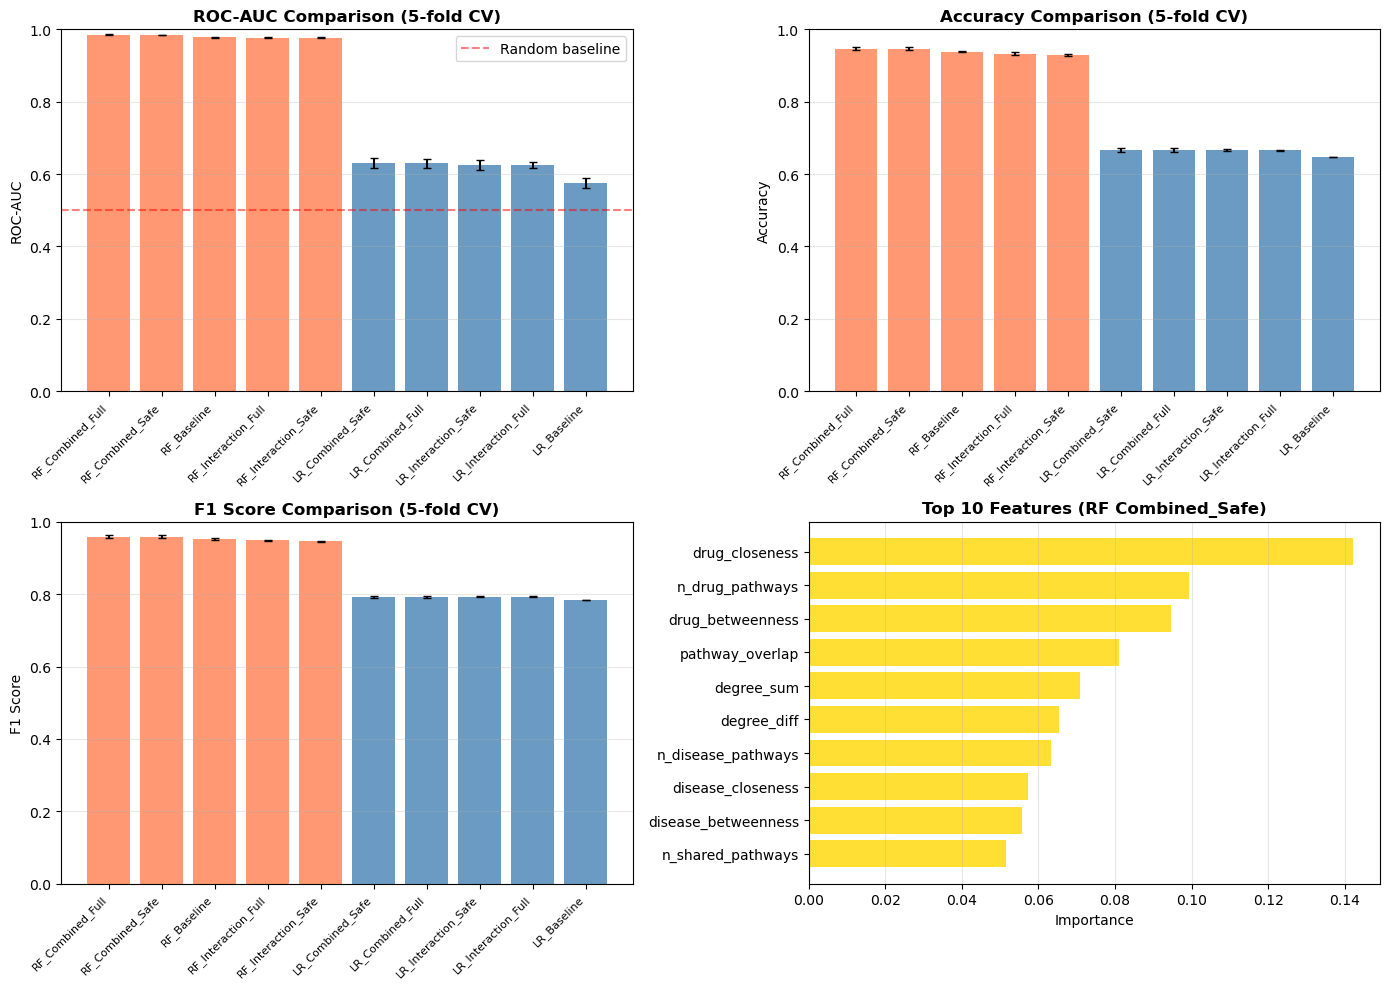


BEST MODEL: RF_Combined_Full
  ROC-AUC: 0.985 ± 0.001
  Accuracy: 0.947 ± 0.005
  F1: 0.959 ± 0.004


In [17]:
# Visualize cross-validation results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Prepare data for plotting
plot_df = results_df.copy()
plot_df['model_type'] = plot_df.index.map(lambda x: 'Logistic Regression' if x.startswith('LR') else 'Random Forest')
plot_df['feature_set'] = plot_df.index.map(lambda x: x.split('_', 1)[1] if '_' in x else x)

# 1. ROC-AUC comparison with error bars
ax = axes[0, 0]
x = range(len(plot_df))
colors = ['steelblue' if 'LR' in idx else 'coral' for idx in plot_df.index]
bars = ax.bar(x, plot_df['roc_auc_mean'], yerr=plot_df['roc_auc_std'], 
              color=colors, capsize=3, alpha=0.8)
ax.set_ylabel('ROC-AUC')
ax.set_title('ROC-AUC Comparison (5-fold CV)', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(plot_df.index, rotation=45, ha='right', fontsize=8)
ax.set_ylim([0, 1])
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random baseline')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 2. Accuracy comparison
ax = axes[0, 1]
bars = ax.bar(x, plot_df['accuracy_mean'], yerr=plot_df['accuracy_std'],
              color=colors, capsize=3, alpha=0.8)
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison (5-fold CV)', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(plot_df.index, rotation=45, ha='right', fontsize=8)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# 3. F1 Score comparison
ax = axes[1, 0]
bars = ax.bar(x, plot_df['f1_mean'], yerr=plot_df['f1_std'],
              color=colors, capsize=3, alpha=0.8)
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score Comparison (5-fold CV)', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(plot_df.index, rotation=45, ha='right', fontsize=8)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# 4. Feature importance
ax = axes[1, 1]
top_n = 10
top_importance = importance_df.head(top_n)
y_pos = range(len(top_importance))
ax.barh(y_pos, top_importance['importance'], color='gold', alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_importance['feature'])
ax.set_xlabel('Importance')
ax.set_title(f'Top {top_n} Features (RF Combined_Safe)', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print best model
best_model = plot_df['roc_auc_mean'].idxmax()
print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model}")
print(f"{'='*60}")
print(f"  ROC-AUC: {plot_df.loc[best_model, 'roc_auc_mean']:.3f} ± {plot_df.loc[best_model, 'roc_auc_std']:.3f}")
print(f"  Accuracy: {plot_df.loc[best_model, 'accuracy_mean']:.3f} ± {plot_df.loc[best_model, 'accuracy_std']:.3f}")
print(f"  F1: {plot_df.loc[best_model, 'f1_mean']:.3f} ± {plot_df.loc[best_model, 'f1_std']:.3f}")

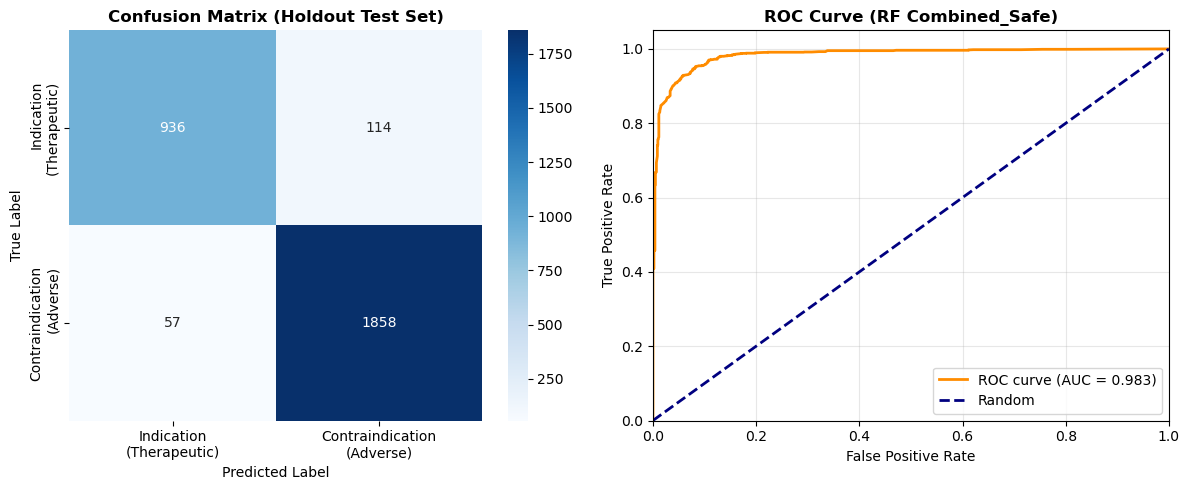


Classification Report (Holdout Test Set):
--------------------------------------------------
                            precision    recall  f1-score   support

  Indication (Therapeutic)       0.94      0.89      0.92      1050
Contraindication (Adverse)       0.94      0.97      0.96      1915

                  accuracy                           0.94      2965
                 macro avg       0.94      0.93      0.94      2965
              weighted avg       0.94      0.94      0.94      2965



In [18]:
# Confusion matrix for best model (using holdout set)
from sklearn.model_selection import train_test_split

# Create a holdout split for confusion matrix visualization
X_train, X_test, y_train, y_test = train_test_split(
    X_combined_safe, y, test_size=0.2, random_state=42, stratify=y
)

# Train best model on training set
best_model_obj = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
best_model_obj.fit(X_train, y_train)
y_pred = best_model_obj.predict(X_test)
y_proba = best_model_obj.predict_proba(X_test)[:, 1]

# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion matrix
ax = axes[0]
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Indication\n(Therapeutic)', 'Contraindication\n(Adverse)'],
            yticklabels=['Indication\n(Therapeutic)', 'Contraindication\n(Adverse)'])
ax.set_title('Confusion Matrix (Holdout Test Set)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

# ROC Curve
from sklearn.metrics import roc_curve, auc
ax = axes[1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve (RF Combined_Safe)', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report (Holdout Test Set):")
print("-" * 50)
print(classification_report(y_test, y_pred, 
                           target_names=['Indication (Therapeutic)', 'Contraindication (Adverse)']))

## 11. Summary & Next Steps

### Key Findings:
1. **Feature Performance**: Which feature set works best?
2. **Model Comparison**: LR vs RF performance
3. **Important Features**: What drives predictions?

### Next Steps for Full Model:
1. **GNN Integration**: Use graph neural networks to capture complex interactions
2. **More Disease Areas**: Expand to additional disease areas
3. **External Data**: Integrate DisGeNET and DrugBank for richer gene mappings
4. **Feature Engineering**: Add temporal, dosage, and patient-specific features
5. **Evaluation**: Cross-validation, external validation sets


## 11. Summary & Next Steps

### Key Findings:
1. **Feature Performance**: Which feature set works best?
2. **Model Comparison**: LR vs RF performance
3. **Important Features**: What drives predictions?

### Next Steps for Full Model:
1. **GNN Integration**: Use graph neural networks to capture complex interactions
2. **More Disease Areas**: Expand to additional disease areas
3. **External Data**: Integrate DisGeNET and DrugBank for richer gene mappings
4. **Feature Engineering**: Add temporal, dosage, and patient-specific features
5. **Evaluation**: Cross-validation, external validation sets


In [19]:
# Final summary with improved methodology
print("=" * 60)
print("MVP SUMMARY (EXPANDED & RIGOROUS EVALUATION)")
print("=" * 60)

print(f"\n📊 DATASET:")
print(f"  Disease areas: {len(selected_disease_ids)} (expanded from 2)")
print(f"  Drugs: {len(selected_drug_ids)} (expanded from 20)")
print(f"  Total examples: {len(df_dataset)}")
print(f"    Positive (contraindication): {int(df_dataset['label'].sum())}")
print(f"    Negative (indication): {len(df_dataset) - int(df_dataset['label'].sum())}")
print(f"    Class balance: {min(df_dataset['label'].mean(), 1-df_dataset['label'].mean()):.1%} minority")

print(f"\n🔬 FEATURES:")
print(f"  Biological features (safe): {len(feature_cols_safe)}")
print(f"  Graph structure features: {len(baseline_cols)}")
print(f"  Total (combined safe): {len(feature_cols_safe) + len(baseline_cols)}")

print(f"\n📈 EVALUATION METHOD:")
print(f"  5-fold stratified cross-validation")
print(f"  ~{len(y)//5} test samples per fold (vs 8 before!)")

best_model_name = results_df['roc_auc_mean'].idxmax()
best_results = results_df.loc[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"  ROC-AUC: {best_results['roc_auc_mean']:.3f} ± {best_results['roc_auc_std']:.3f}")
print(f"  Accuracy: {best_results['accuracy_mean']:.3f} ± {best_results['accuracy_std']:.3f}")
print(f"  F1 Score: {best_results['f1_mean']:.3f} ± {best_results['f1_std']:.3f}")

# Interpret results
print(f"\n💡 INTERPRETATION:")
if best_results['roc_auc_mean'] > 0.7:
    print("  ✓ Model shows meaningful predictive power (ROC-AUC > 0.7)")
else:
    print("  ⚠ Model shows limited predictive power (ROC-AUC ≤ 0.7)")

if best_results['roc_auc_std'] < 0.05:
    print("  ✓ Results are stable across folds (std < 0.05)")
else:
    print("  ⚠ High variance across folds - results may be unreliable")

# Compare feature sets
baseline_auc = results_df.loc['RF_Baseline', 'roc_auc_mean'] if 'RF_Baseline' in results_df.index else 0
combined_auc = results_df.loc['RF_Combined_Safe', 'roc_auc_mean'] if 'RF_Combined_Safe' in results_df.index else 0
if combined_auc > baseline_auc + 0.02:
    print("  ✓ Biological features add value beyond graph structure")
else:
    print("  ⚠ Biological features don't significantly improve over baseline")

print(f"\n🔮 NEXT STEPS:")
print("  1. Add more diverse diseases (different therapeutic areas)")
print("  2. Implement disease-level cross-validation (train/test on different diseases)")
print("  3. Try GNN models to capture deeper graph patterns")
print("  4. Add drug chemical structure features (fingerprints)")
print("  5. External validation on newly approved drugs")

print("\n" + "=" * 60)

MVP SUMMARY (EXPANDED & RIGOROUS EVALUATION)

📊 DATASET:
  Disease areas: 328 (expanded from 2)
  Drugs: 1000 (expanded from 20)
  Total examples: 14824
    Positive (contraindication): 9574
    Negative (indication): 5250
    Class balance: 35.4% minority

🔬 FEATURES:
  Biological features (safe): 7
  Graph structure features: 8
  Total (combined safe): 15

📈 EVALUATION METHOD:
  5-fold stratified cross-validation
  ~2964 test samples per fold (vs 8 before!)

🏆 BEST MODEL: RF_Combined_Full
  ROC-AUC: 0.985 ± 0.001
  Accuracy: 0.947 ± 0.005
  F1 Score: 0.959 ± 0.004

💡 INTERPRETATION:
  ✓ Model shows meaningful predictive power (ROC-AUC > 0.7)
  ✓ Results are stable across folds (std < 0.05)
  ⚠ Biological features don't significantly improve over baseline

🔮 NEXT STEPS:
  1. Add more diverse diseases (different therapeutic areas)
  2. Implement disease-level cross-validation (train/test on different diseases)
  3. Try GNN models to capture deeper graph patterns
  4. Add drug chemical 